# Report for Statistics Course 2024
#### Mikael Folkesson, AI-23

## Introduction
I chose to explore the auto-mpg dataset consisting of 398 cars produced between 1970-1982, and collected by the *American Statistical Association* in 1983. Given that the dataset is American, it might well be biased and not representative of all European and Japanese cars available on the market in Europe and Japan at the time. We will assume that it's fairly representative, but keep the possible bias in mind. 

I will pursue two research questions, the first a hypothesis test, and the second a linear regression analysis including prediction:
1. **Can we, with 99% certainty, say that there was a difference in fuel comsumption between American, European, and Japanese cars** in the years 1970-1982.
2. **Can we predict a car's fuel consumption based on its weight and horse powers?**

## Initial data exploration

In [1]:
import numpy as np
import pandas as pd
    
# Import Car Data
filepath = 'Data/auto-mpg.csv'
cars = pd.read_csv(filepath)

In [20]:
# Initial overview of the data
print(cars.info())
print(cars.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mpg           398 non-null    float64
 1   cylinders     398 non-null    int64  
 2   displacement  398 non-null    float64
 3   horsepower    392 non-null    float64
 4   weight        398 non-null    int64  
 5   acceleration  398 non-null    float64
 6   model_year    398 non-null    int64  
 7   origin        398 non-null    object 
 8   name          398 non-null    object 
dtypes: float64(4), int64(3), object(2)
memory usage: 28.1+ KB
None
              mpg   cylinders  displacement  horsepower       weight  \
count  398.000000  398.000000    398.000000  392.000000   398.000000   
mean    23.514573    5.454774    193.425879  104.469388  2970.424623   
std      7.815984    1.701004    104.269838   38.491160   846.841774   
min      9.000000    3.000000     68.000000   46.000000  1613.00000

The dataset contains 398 cars and has the following columns, whose contents are trivial given their names:
- **mpg**: Miles per gallon, a measure of fuel efficiency.
- **cylinders**: The number of cylinders in the engine.
- **displacement**: Engine displacement.
- **horsepower**: Engine power.
- **weight**: Weight of the car.
- **acceleration**: Acceleration.
- **model_year**: The year of the model.
- **origin**: The origin of the car (i.e., USA, Europe, or Japan).
- **name**: The name of the car model.

We see that there are only 6 missing values in the horsepower column, and as we initially don't intend to use that column there's currently no need to drop those rows.

## Research Question 1 (hypothesis test):
### Can we, with 95% confidence, say that there was a difference in fuel comsumption between American, European, and Japanese cars in the years 1970-1982?

In [21]:
# Let's begin by converting fuel consumption from mpg to l/10km (common in Sweden)
cars['l/10km'] = 23.5215/cars['mpg']
cars.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,name,l/10km
0,18.0,8,307.0,130.0,3504,12.0,70,usa,chevrolet chevelle malibu,1.306750
1,15.0,8,350.0,165.0,3693,11.5,70,usa,buick skylark 320,1.568100
2,18.0,8,318.0,150.0,3436,11.0,70,usa,plymouth satellite,1.306750
3,16.0,8,304.0,150.0,3433,12.0,70,usa,amc rebel sst,1.470094
4,17.0,8,302.0,140.0,3449,10.5,70,usa,ford torino,1.383618


In [22]:
# Check number of cars per origin
print(cars['origin'].value_counts())

origin
usa       249
japan      79
europe     70
Name: count, dtype: int64


As there is a sufficient amount of cars of each category of origin, we can continue with this research question.

In [23]:
# Segmenting the data based on the origin
american_cars = cars[cars['origin'] == 'usa']
european_cars = cars[cars['origin'] == 'europe']
japanese_cars = cars[cars['origin'] == 'japan']

# Calculating descriptive statistics for each segment
american_stats = american_cars['l/10km'].describe()
european_stats = european_cars['l/10km'].describe()
japanese_stats = japanese_cars['l/10km'].describe()

#Combine the statistics into a dataframe
statistics = pd.DataFrame({'USA': american_stats, 'Europe': european_stats, 'Japan': japanese_stats})
print(statistics)

              USA     Europe      Japan
count  249.000000  70.000000  79.000000
mean     1.285942   0.891168   0.806317
std      0.384333   0.211338   0.176842
min      0.603115   0.530959   0.504753
25%      0.980062   0.767429   0.690794
50%      1.271432   0.887920   0.744351
75%      1.568100   0.980062   0.915358
max      2.613500   1.451944   1.306750


The average fuel consumption is 1.3, 0.9 and 0.8 liters/10km respectively. Let's visualize the findings to get an intial feeling of the distribution:

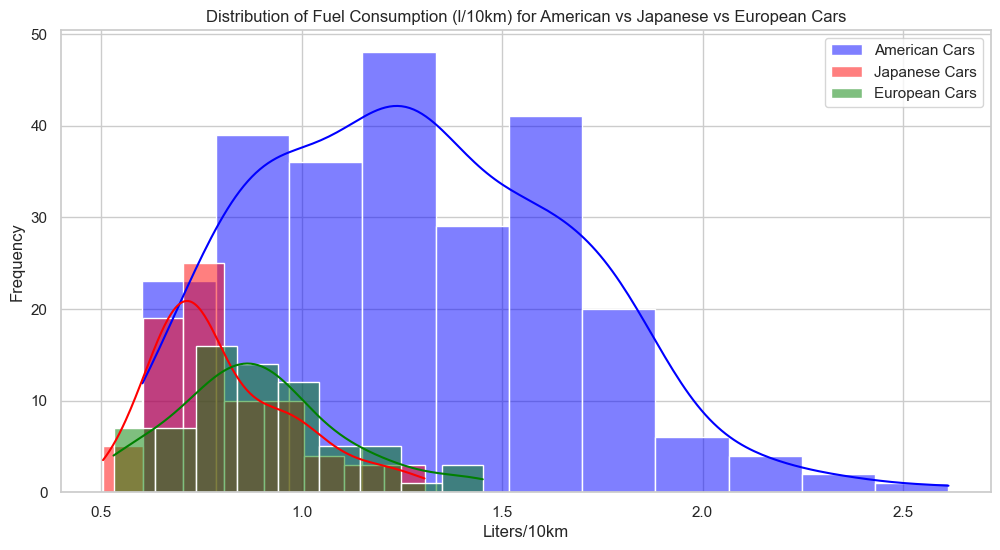

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

# Setting up the visualization style
sns.set(style="whitegrid")

# Plotting the distribution of fuel consumption for each origin
plt.figure(figsize=(12, 6))
sns.histplot(american_cars['l/10km'], color="blue", label='American Cars', kde=True)
sns.histplot(japanese_cars['l/10km'], color="red", label='Japanese Cars', kde=True)
sns.histplot(european_cars['l/10km'], color="green", label='European Cars', kde=True)

plt.title('Distribution of Fuel Consumption (l/10km) for American vs Japanese vs European Cars')
plt.xlabel('Liters/10km')
plt.ylabel('Frequency')
plt.legend()

plt.show()

From this visual we see that especially the Japanese cars were geared towards better fuel effeciency with the peak around 0.6-0.7 l/10km, followed by the European cars with a peak around 0.7-0.8. The bulk of the American cars are more spread out, ranging between something like 0.8 and 1.6.

Let's narrow it down a bit more using a boxplot.

In [25]:
import plotly.express as px

# Boxplot of fuel consumption for each origin
fig = px.box(cars, x='origin', y='l/10km', color='origin',
             labels={'origin': 'Region', 'l/10km': 'Liters per 10 km'},
             title='Comparison of fuel consumption: American vs European Cars')
fig.show()

Above, our conclusions from the previous visual are supported by Japan generally having  a bit less fuel consumption than Europe, and the bulk of them (the IQR representing 50% of the data) all being separate from that of the bulk of America.

### Hypothesis tests
The next step is to conduct a hyptothesis test to determine if the observed difference in fuel consumption between cars of the different origins is statistically significant. Since the standard deviation for the population is unknown, we will use a t-test, and the significance level will be set at 1% (α=0.01), because we want to be as certain as possible and avoid type I errors for some reason.

We will compare them in this order:
- American vs. European Cars
- American vs. Japanese Cars
- European vs. Japanese Cars

Let's begin comparinging the American cars to the European Cars.

#### American vs. European Cars
The hypotheses:<br><br>
    $H_0: \mu_{\text{American}} \leq \mu_{\text{European}}$<br>
    $H_A: \mu_{\text{American}} \gt \mu_{\text{European}}$

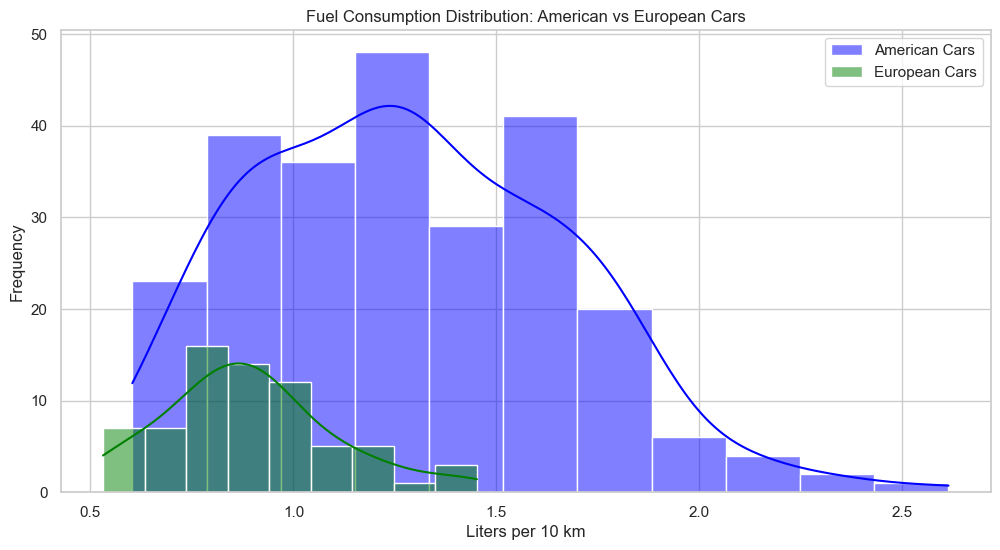

In [26]:
# Visual Analysis just to focus our attention on the American and European cars
plt.figure(figsize=(12, 6))
sns.histplot(american_cars['l/10km'], color="blue", label='American Cars', kde=True)
sns.histplot(european_cars['l/10km'], color="green", label='European Cars', kde=True)
plt.title('Fuel Consumption Distribution: American vs European Cars')
plt.xlabel('Liters per 10 km')
plt.ylabel('Frequency')
plt.legend()
plt.show()

Next, let's find out the T-statistic and the P-value. These are two ways of knowing whether to refute the null hypothesis (H₀) or not. The T-statistic will be compared to the critical T-value. These both indicate the number of standard deviations from the mean. The P-value will be compared to the chosen significance level α=0.01. 

The formula for calculating the t-value follows. We don't really need to know it here when using the library, instead we let the computer do the work. But it's so pretty and scientific looking:
<h3>

$t = \frac{\overline{X} - \mu_0}{s \,/\sqrt{n}}$
</h3>

In [27]:
import scipy.stats as stats 
# Hypothesis Testing - T-Test
t_stat, p_value = stats.ttest_ind(american_cars['l/10km'], european_cars['l/10km'], equal_var=False)

print(f"T-Statistic: {t_stat}")
print(f"P-Value: {p_value}")

T-Statistic: 11.250491510741794
P-Value: 3.164277204838178e-23


- **T-Statistic:** $11.250$
- **P-value:** $3.16 \times 10^{-23}$

In [28]:
# Now let's find the critical t-value
alpha = 0.01
df = len(american_cars) + len(european_cars) - 2
t_crit = stats.t.ppf(1-alpha, df)
print(f"Critical T-value: {t_crit:.4f}")

Critical T-value: 2.3382


#### Conclusion (American vs European) 
The extremely low p-value $3.16 \times 10^{-23}$, which is but a fraction of the significance level α=0.01, and the fact that the t-statistic 11.25 vastly exceeds the critical t-value 2.34, indicates that the difference in mean fuel consumption between American and European cars is quite statistically significant. We have enough evidence to dismiss H₀ and with at least 99% confidence say that European cars, on average, had higher fuel efficiency than American cars, based on the dataset.

### American vs. Japanese Cars

Now, let's do the same when comparing American to Japanese cars.

The hypotheses:<br><br>
    $H_0: \mu_{\text{American}} \leq \mu_{\text{Japanese}}$<br>
    $H_A: \mu_{\text{American}} \gt \mu_{\text{Japanese}}$

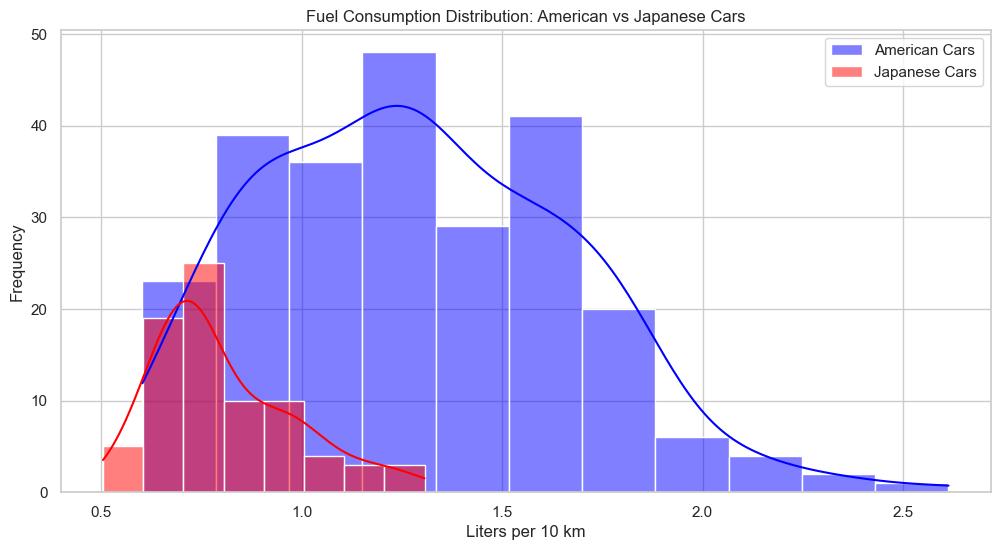

T-Statistic: 15.250545236614984
P-Value: 8.083126255446127e-39


In [29]:
# Visual Analysis
plt.figure(figsize=(12, 6))
sns.histplot(american_cars['l/10km'], color="blue", label='American Cars', kde=True)
sns.histplot(japanese_cars['l/10km'], color="red", label='Japanese Cars', kde=True)
plt.title('Fuel Consumption Distribution: American vs Japanese Cars')
plt.xlabel('Liters per 10 km')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# Hypothesis Testing - T-Test
t_stat, p_value = stats.ttest_ind(american_cars['l/10km'], japanese_cars['l/10km'], equal_var=False)

print(f"T-Statistic: {t_stat}")
print(f"P-Value: {p_value}")

- **T-Statistic:** $15.251$
- **P-value:** $8.08 \times 10^{-39}$

In [30]:
# Checking the critical t-value
alpha = 0.01
df = len(american_cars) + len(japanese_cars) - 2
t_crit = stats.t.ppf(1-alpha, df)
print(f"Critical T-value: {t_crit:.4f}")

Critical T-value: 2.3378


#### Conclusion (American vs Japanese) 
The even more extremely low p-value, and the fact that the t-statistic again vastly exceeds the critical t-value, indicates that the difference in mean fuel consumption between American and Japanese cars is statistically significant. We can easily say with a 99% confidence that Japanese cars, on average, based on the dataset, have higher fuel efficiency than American cars.

### European vs. Japanese Cars

And the final test for this research question: European cars compared to Japanese, the outcome of which seems to be much more uncertain.

The hypotheses:<br><br>
    $H_0: \mu_{\text{European}} \leq \mu_{\text{Japanese}}$<br>
    $H_A: \mu_{\text{European}} \gt \mu_{\text{Japanese}}$

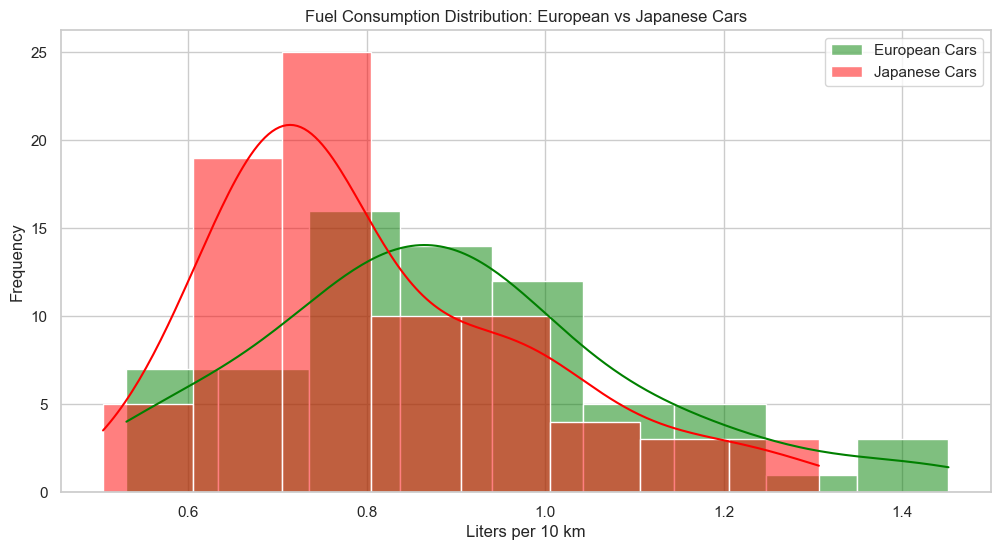

T-Statistic: 2.6388254256392267
P-Value: 0.009296377057011857


In [31]:
# Visual Analysis
plt.figure(figsize=(12, 6))
sns.histplot(european_cars['l/10km'], color="green", label='European Cars', kde=True)
sns.histplot(japanese_cars['l/10km'], color="red", label='Japanese Cars', kde=True)
plt.title('Fuel Consumption Distribution: European vs Japanese Cars')
plt.xlabel('Liters per 10 km')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# Hypothesis Testing - T-Test
t_stat, p_value = stats.ttest_ind(european_cars['l/10km'], japanese_cars['l/10km'], equal_var=False)

print(f"T-Statistic: {t_stat}")
print(f"P-Value: {p_value}")

- **T-Statistic:** $2.6388$
- **P-value:** $0.0093$

In [32]:
# Checking the critical t-value
alpha = 0.01
df = len(european_cars) + len(japanese_cars) - 2
t_crit = stats.t.ppf(1-alpha, df)
print(f"Critical T-value: {t_crit:.4f}")


Critical T-value: 2.3520


#### Conclusion (European vs Japanese) 
With a p-value slightly less than the significance level ($0.0093 \lt 0.01$), corroborated by the t-statistic being a bit larger than the critical t-value ($2.6388 \gt 2.352$), means that it is unlikely that the findings are a result of chance, therefore we reject the null hypothesis also in this case. 
This means that we have enough evidence to, with 99% confidence, conclude that Japanese cars, on average and based on the dataset, had a higher fuel efficiency than European cars in the 1970's.

### General Conclusion of First Research Question
We have enough statistical evidence to conclude, with 99% confidence, that American made cars in the 1970's on average consumed a lot more fuel than their European and Japanese counterparts sold in America, based on the provided dataset. The difference really was huge.

There is also enough evidence to, with a 99% confidence (α=0.01), conclude the same in the comparison between European and Japanese made cars. But the race was much closer.

#### Possible Contributing Factors
- It is reasonable to infer *a priori* that higher fuel taxes in Europe and Japan made fuel efficiency a more critical selling point for vehicles.
- Europe and Japan have less oil than America, and are more dependent on imports. As there was a coordinated tightening of the oil supply from OPEC in the 1970's, that likely hit Europe and Japan harder.
- European and Japanese markets, with higher fuel costs and narrower streets, demanded smaller, more efficient cars.
- A higher GDP/capita and higher living standards in America gave the consumers a buffer, making them less inclined to look for more fuel efficient cars.


## Research Question 2 (Linear Regression and Prediction):
### Can we predict a car's fuel consumption based on its weight and horse power?
To determine this, we will perform a regression analysis. We will consider an R² value > 0.8 to be sufficient (capital R as we will be using more than one independent variable).

As there are 6 missing values regarding horse power, which is a relatively small number, it would probably not affect the general findings much by simply dropping those rows.

In [33]:
cars = cars.dropna() # drop missing values

Now, let's find out what factors correlate most with fuel consumption:

In [34]:
corr = cars[['cylinders','displacement','horsepower','weight','acceleration','model_year','l/10km']].corr()
corr

,cylinders,displacement,horsepower,weight,acceleration,model_year,l/10km
cylinders,1.000000,0.950823,0.842983,0.897527,-0.504683,-0.345647,0.839385
displacement,0.950823,1.000000,0.897257,0.932994,-0.543800,-0.369855,0.866050
horsepower,0.842983,0.897257,1.000000,0.864538,-0.689196,-0.416361,0.854809
weight,0.897527,0.932994,0.864538,1.000000,-0.416839,-0.309120,0.885056
acceleration,-0.504683,-0.543800,-0.689196,-0.416839,1.000000,0.290316,-0.456338
model_year,-0.345647,-0.369855,-0.416361,-0.309120,0.290316,1.000000,-0.558255
l/10km,0.839385,0.866050,0.854809,0.885056,-0.456338,-0.558255,1.000000


<Axes: >

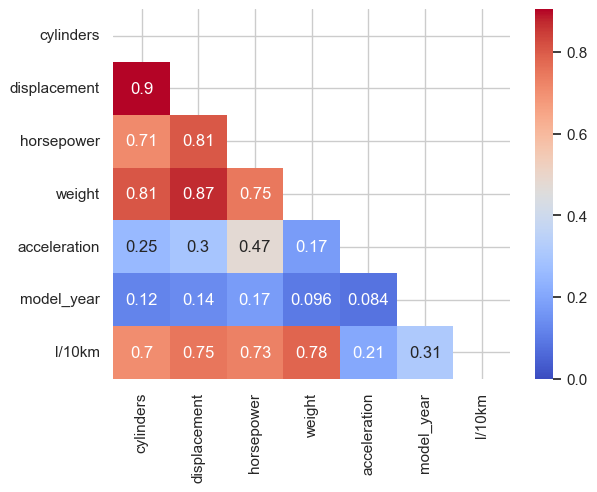

In [40]:
# Visual inspection of the correlation matrix
mask = np.triu(np.ones_like(corr, dtype=bool))

# Checking the correlation matrix squared to get the r-squared values
sns.heatmap(corr**2, vmin=0, mask=mask, annot=True ,cmap='coolwarm') 

Using the squared number corresponding to the r², we see that the top three factors correlating to fuel consumption are weight, displacement, and horsepower.
We could use all three of these factors for our prediction. But as the research question has already been set, we will proceed without displacement, which is also highly correlated to the weight. This makes it feel more ok to skip including that factor.

Now, let's inspect the correlation between the chosen factors visually.

In [41]:
# Plot the relationship between weight and fuel consumption globally
fig = px.scatter(cars, x="weight", y="l/10km", trendline="ols", title="Relationship between Weight and Fuel Consumption")
fig.update_traces(marker=dict(size=8, opacity=0.8))
fig.update_layout(
    xaxis_title="Weight",
    yaxis_title="Fuel Consumption (l/10km)",
    font=dict(
        family="Arial",
        size=14,
        color="black"
    ),
    height=600
)
fig.show()

At first glance, this seems to be correlating well globally, with no weird clusters or such.  

But how about the relation to horse powers? 

In [42]:
# Plot the relationship between horse power and fuel consumption 
fig = px.scatter(cars, x="horsepower", y="l/10km", trendline="ols", title="Relationship between Horse power and Fuel Consumption")
fig.update_traces(marker=dict(size=8, opacity=0.8))
fig.update_layout(
    xaxis_title="Horse power",
    yaxis_title="Fuel Consumption (l/10km)",
    font=dict(
        family="Arial",
        size=14,
        color="black"
    ),
    height=600
)
fig.show()

We conclude that both parameters seem to be fairly well correlated to fuel consumption, and no issues have arisen during this visual inspection. Let's try to use both *in combination* for our linear regression.

Now we train a model using *Scikit Learn* and see if we can use it to make predictions based on the research question.

We will split the dataset up in a test set, comprising 20% of the data, and a training set comprising the remainder. We will use Linear Regression, and use both dimensions 'weight' and 'horsepower' as independent variables.

In [45]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Splitting the data into training and testing sets.
X = cars[['weight', 'horsepower']]
y = cars['l/10km']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

model = LinearRegression()

# Train the model
model.fit(X_train, y_train)

# Make predictions using the testing set
y_pred = model.predict(X_test)

# Calculate the coefficients, mean squared error, and the coefficient of determination (R^2)
coefficients = model.coef_
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
intercept = model.intercept_

print(f"Intercept (β₀): {intercept}")
print(f"Coefficients (β₁, β₂): {coefficients}")
print(f"Mean Squared Error: {mse}")
print(f"Coefficient of determination (R²): {r2}")


Intercept (β₀): -0.060161465357086996
Coefficients (β₁, β₂): [0.000273   0.00356769]
Mean Squared Error: 0.030789795256755386
Coefficient of determination (R²): 0.8049807099996057


Given the prediction formula for linear regression using multiple independent variables: 

$y = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + ... + \beta_n x_n + \epsilon$

We get $β₀=-0.060161, β₁=0.000273, β₂=0.00356769$, and 
$\sum_{i=1}^{n} \epsilon_i^2=MSE=0.030789795$

Additionally, $ R²=0.805 $, which means that about 80.5% of the variability in fuel consumption can be explained by the model that includes the car's weight and horsepower as independent variables, which is a relatively high value, suggesting a strong correlation and a good fit of the model to the data. It is also slightly higher than the value from the heatmap for only the weight (0.78), implying a slight benefit by using both factors for the predictions.

## Conclusion 
This fulfills the requirement defined at the outset, with $ 0.805 \gt 0.8 $, lettings us conclude that we can use the dimensions of weight and horse power to predict the fuel consumption of a car to a sufficient degree of accuracy. 

## Bonus materials

For fun, here's a program that takes weight and horsepowers of a car and spits out the estimated fuel consumption.

In [ ]:
# Coefficients obtained from the linear regression model
weight_coefficient = coefficients[0]
horsepower_coefficient = coefficients[1]

# Convert weight from kg to lbs
def convert_kgtoibs(weight):
    return weight * 2.20462
# Convert weight from kg to lbs
def convert_ibstokg(weight):
    return weight / 2.20462

def calculate_fuel_consumption(weight, horsepower):
    return intercept + weight * weight_coefficient + horsepower * horsepower_coefficient

# Get inputs from the user. Error handling is not implemented, due to this being a simple example.
weight = convert_kgtoibs(float(input("Enter the weight of the car (kilograms): ")))
horsepower = float(input("Enter the horsepower of the car: "))

# Calculate fuel consumption
fuel_consumption = calculate_fuel_consumption(weight, horsepower)

print(f"Estimated fuel consumption for a car weighing {convert_ibstokg(weight)} kg with {horsepower:} horsepowers: {fuel_consumption:.2} l/10km.")


What happens when we perform the test using MPG instead of l/10km?

In [44]:
# Splitting the data into training and testing sets. Usually 20% of the data is used for testing apparently.
X = cars[['weight', 'horsepower']]
y = cars['mpg']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

model = LinearRegression()

# Train the model
model.fit(X_train, y_train)

# Make predictions using the testing set
y_pred = model.predict(X_test)

# Calculate the coefficients, mean squared error, and the coefficient of determination (R^2)
coefficients = model.coef_
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
intercept = model.intercept_

print(f"Intercept (β₀): {intercept}")
print(f"Coefficients (β₁, β₂): {coefficients}")
print(f"Mean Squared Error: {mse}")
print(f"Coefficient of determination (R²): {r2}")

Intercept (β₀): 45.96119618245666
Coefficients (β₁, β₂): [-0.00602569 -0.04392749]
Mean Squared Error: 18.793730732283095
Coefficient of determination (R²): 0.697632764364343



Interestingly, when performing the test in MPG instead of l/10km, all else equal, R²=69.8%. This in itself if a factor in not putting as much weight (pun intended) to the weight and hp when it comes to fuel consumption in America. This means choosing the unit for a measurement is also something that can be used in manipulative ways, and something to be aware of.

### Creating an out of sample plot for the prediction

Creating an out-of-sample prediction allows us to assess the model's performance on data it has not seen during training, providing a realistic measure of its generalization ability and effectiveness in making accurate predictions in real-world scenarios. This plot was made using a little help from a friend (ChatGPT). It is interactive and rotatable.

In [51]:
# Generate Extended Data for Prediction
max_weight = X_test['weight'].max()
max_horsepower = X_test['horsepower'].max()

# Creating a grid of values for weight and horsepower
weight_extended = np.linspace(X_test['weight'].min(), max_weight * 2, 20)
horsepower_extended = np.linspace(X_test['horsepower'].min(), max_horsepower * 2, 20)
weight_grid, horsepower_grid = np.meshgrid(weight_extended, horsepower_extended)

# Create a DataFrame for easy prediction
extended_df = pd.DataFrame({
    'weight': weight_grid.ravel(),
    'horsepower': horsepower_grid.ravel(),
})

# Predict Using Extended Data
extended_predictions = model.predict(extended_df)

import plotly.graph_objects as go

# Create a 3D scatter plot with Plotly
fig = go.Figure()

# Actual data
fig.add_trace(go.Scatter3d(x=X_test['weight'], y=X_test['horsepower'], z=y_test,
                           mode='markers', name='Actual'))

# Predicted data (original)
fig.add_trace(go.Scatter3d(x=X_test['weight'], y=X_test['horsepower'], z=y_pred,
                           mode='markers', name='Predicted', marker=dict(size=5)))

# Extended predictions
fig.add_trace(go.Scatter3d(x=extended_df['weight'], y=extended_df['horsepower'], z=extended_predictions,
                           mode='markers', name='Extended Predictions', marker=dict(size=3, color='green')))

fig.update_layout(
    scene=dict(
        xaxis_title='Weight',
        yaxis_title='Horsepower',
        zaxis_title='l/10km'
    ),
    title='Interactive 3D Plot of Actual vs. Predicted Values with Extended Predictions',
    height=800
)

fig.show()


Granted, it does make less sense to do this than for a single independent variable, where you can easily see the confidence interval, but here we see the plane of predictions based on different values of the two independent variables (weight, horse power) x₁ and x₂, weighted by their corresponding coefficients β₁, β₂.